# Mixed State Preparation
Quantum Neural Network (QNN) to prepare a mixed state via purification

In [1]:
import tensorflow as tf

import strawberryfields as sf
from strawberryfields.ops import *

from qutip import rand_dm_ginibre

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output

## Constants

### Dataset

In [2]:
n_qumodes = 2
size_system = n_qumodes * 2 # for purification

cutoff = 3

n_samples = 1000

size_hilbert = cutoff**n_qumodes

### State preparation

In [3]:
n_layers = 20

# Standard deviation of initial parameters
passive_std = 0.1
active_std = 0.001

## Creation of the dataset

In [4]:
def purity_fct(rho, backend="np"):
    if backend == "np":
        return np.real(np.trace(rho @ rho))
    if backend == "tf":
        return tf.real(tf.trace(rho @ rho))
    else:
        raise ValueError("Backend must be in ['tf', 'np']. Currently {}".format(backend))

In [5]:
epsilon = 0.05

In [7]:
rhos = []
list_p = np.arange(0.2, 1, epsilon)
for i, p in enumerate(list_p): # for each purity
    while len(rhos) <= (i+1)*(int(n_samples/len(list_p))):
        # generate size_hilbert λi s.t. sum(λi)=1
        curr_max = 1
        lambda_list = []
        for j in range(size_hilbert-1):
            λ = np.random.uniform(0,curr_max)
            curr_max -= λ
            lambda_list.append(λ)
        lambda_list.append(1-sum(lambda_list)) 
        lambda_list = np.array(lambda_list)
        purity = sum(lambda_list**2)
        if p <= purity <= p+epsilon:
            U = sp.stats.unitary_group.rvs(size_hilbert)
            rhos.append(U@np.diag(np.random.permutation(lambda_list))@np.conj(U).T)
rhos = np.array(rhos)

In [8]:
rhos = np.random.permutation(rhos)

In [9]:
purities = np.array([purity_fct(rho) for rho in rhos])

(array([1.13653498, 1.43961098, 1.26281665, 1.13653498, 1.33858565,
        1.21230398, 1.38909831, 1.23756032, 1.18704765, 1.23756032,
        1.26281665, 1.23756032, 1.06076599, 1.43961098, 1.23756032,
        1.28807298, 1.26281665, 1.18704765, 1.23756032, 1.28807298]),
 array([0.20150283, 0.24137597, 0.28124911, 0.32112225, 0.3609954 ,
        0.40086854, 0.44074168, 0.48061482, 0.52048796, 0.5603611 ,
        0.60023425, 0.64010739, 0.67998053, 0.71985367, 0.75972681,
        0.79959995, 0.8394731 , 0.87934624, 0.91921938, 0.95909252,
        0.99896566]),
 <a list of 20 Patch objects>)

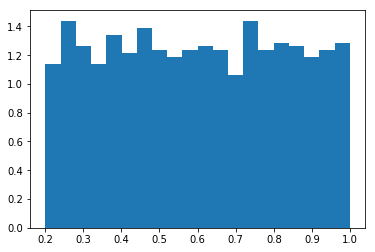

In [10]:
plt.hist(purities, density=True, bins=20)

## State preparation procedure

### Placeholders

In [11]:
rho_input = tf.placeholder(tf.complex64, [size_hilbert, size_hilbert])
lr_placeholder = tf.placeholder(tf.float32)

### Parameters

In [12]:
# Initial parameters

# squeeze gate
sq_r = tf.Variable(tf.random_normal(shape=[n_layers, size_system], stddev=active_std))
sq_phi = tf.Variable(tf.random_normal(shape=[n_layers, size_system], stddev=passive_std))

# displacement gate
d_r = tf.Variable(tf.random_normal(shape=[n_layers, size_system], stddev=active_std))
d_phi = tf.Variable(tf.random_normal(shape=[n_layers, size_system], stddev=passive_std))

# interferometer
inter_theta = tf.Variable(tf.random_normal(shape=[n_layers*2, int(size_system*(size_system-1)/2)], stddev=passive_std))
inter_phi = tf.Variable(tf.random_normal(shape=[n_layerparameters = [sq_r, sq_phi, d_r, d_phi, inter_theta, inter_phi, inter_rphi, kappa]s*2, int(size_system*(size_system-1)/2)], stddev=passive_std))
inter_rphi = tf.Variable(tf.random_normal(shape=[n_layers*2, size_system-1], stddev=passive_std))

# kerr gate
kappa = tf.Variable(tf.random_normal(shape=[n_layers, size_system], stddev=active_std))

In [13]:
parameters = [sq_r, sq_phi, d_r, d_phi, inter_theta, inter_phi, inter_rphi, kappa]

### Construct the circuit

In [14]:
def Interferometer(theta, phi, rphi, q):
	# parameterised interferometer acting on N qumodes
    # theta is a list of length N(N-1)/2
    # phi is a list of length N(N-1)/2
    # rphi is a list of length N-1
	# q is the list of qumodes the interferometer is to be applied to
    N = len(q)

    if N == 1:
        # the interferometer is a single rotation
        Rgate(rphi[0]) | q[0]
        return

    n = 0 # keep track of free parameters

    # Apply the Clements beamsplitter array
    # The array depth is N
    for l in range(N):
        for k, (q1, q2) in enumerate(zip(q[:-1], q[1:])):
            #skip even or odd pairs depending on layer
            if (l+k)%2 != 1:
                BSgate(theta[n], phi[n]) | (q1, q2)
                n += 1

    # apply the final local phase shifts to all modes except the last one
    for i in range(len(q)-1):
        Rgate(rphi[i]) | q[i]

In [15]:
def layer(i, q, params):
    sq_r, sq_phi, d_r, d_phi, inter_theta, inter_phi, inter_rphi, kappa = tuple(params)
    
    Interferometer(inter_theta[2*i], inter_phi[2*i], inter_rphi[2*i], q)
    
    for j in range(len(q)):
        Sgate(sq_r[i,j], sq_phi[i,j]) | q[j]
        
    Interferometer(inter_theta[2*i+1], inter_phi[2*i+1], inter_rphi[2*i+1], q)
    
    for j in range(len(q)):
        Dgate(d_r[i,j], d_phi[i,j]) | q[j]
        
    for j in range(len(q)):
        Kgate(kappa[i,j]) | q[j]

    return q

In [16]:
def state_preparation(q):
    for i in range(n_layers):
        layer(i, q, parameters)

In [17]:
# Start SF engine
engine, q = sf.Engine(n_qumodes*2)

# Apply circuit of layers with corresponding depth
with engine:
    state_preparation(q)

In [18]:
# Run engine
state = engine.run('tf', cutoff_dim=cutoff, eval=False, modes=[0,1])
reduced_dm = tf.reshape(tf.einsum('ijkl->ikjl', state.dm()), (size_hilbert, size_hilbert))
purity_output = tf.real(tf.trace(reduced_dm @ reduced_dm))

### Cost and optimizer

In [19]:
def normed_cost_function(rho1, rho2):
    return tf.real(tf.norm(rho1 - rho2, axis=(0,1)))

def eigen_cost_function(rho1, rho2):
    return tf.reduce_mean(tf.square(tf.real(tf.linalg.eigvalsh(rho1 - rho2))))
#     return tf.reduce_mean(tf.square(tf.real(tf.linalg.eigvalsh(rho1) - tf.linalg.eigvalsh(rho2))))
def purity_cost_function(rho1, rho2):
    return tf.square(purity_fct(rho1, "tf") - purity_fct(rho2, "tf"))

In [20]:
cost = eigen_cost_function(reduced_dm, rho_input) + 10 * purity_cost_function(reduced_dm, rho_input)

In [21]:
optimiser = tf.train.AdamOptimizer(learning_rate=lr_placeholder)
min_cost = optimiser.minimize(cost)

### Training

In [22]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [31]:
# cost_list = []
# purity_list = []
cost_list = []
purity_list = []
i = 0

In [44]:
nb_iters = 10000
lr = 4e-3
rho_index = 1
avg_lrs = 10

for i in range(i, nb_iters+i):
#     if i > avg_lrs and np.mean(cost_list[-avg_lrs:]) > np.mean(cost_list[-avg_lrs*2:-avg_lrs]):
#         print("Divide learning rate")
#         lr /= 2
        
    _, curr_cost = sess.run([min_cost, cost], feed_dict={rho_input: rhos[rho_index], lr_placeholder: lr})
    curr_purity = sess.run(purity_output, feed_dict={rho_input: rhos[rho_index]})
        
    cost_list.append(curr_cost)
    purity_list.append(curr_purity)
    
    clear_output(wait=True)
    print('Cost after step {:5d}: {: .7f}'.format(i, cost_list[-1]))
    print('Purity: {:.7f}'.format(purity_list[-1]))
i = i+1

Cost after step  6207:  0.0000304
Purity: 0.9728807


KeyboardInterrupt: 

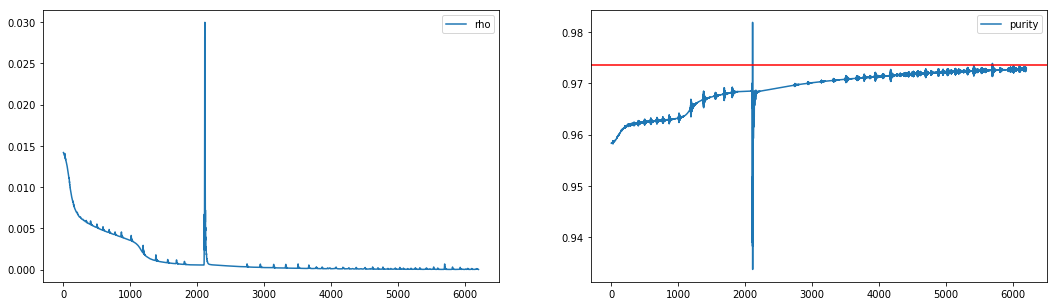

In [45]:
start = 0

plt.rcParams['figure.figsize'] = (18,5)
plt.subplot(1,2,1)
plt.plot(cost_list[start:], label="rho")
# plt.plot(cost2_list[start:], label="rho with penalty")
# plt.plot(cost3_list[start:], label="rho with 10x penalty")
plt.legend()
plt.subplot(1,2,2)
plt.plot(purity_list[start:], label="purity")
# plt.plot(purity2_list[start:], label="purity with penalty")
# plt.plot(purity3_list[start:], label="purity with 10x penalty")
plt.axhline(y=purities[rho_index], color='r', linestyle='-')
plt.legend()
# plt.yscale('log')

In [ ]:
pred_dm = sess.run(reduced_dm)

# Creation of the dataset
Using a Monte Carlo method

In [ ]:
epsilon = 0.05
nb_samples = 3000

In [ ]:
list_rhos = []
list_p = np.arange(0.2, 1, epsilon)
for i, p in enumerate(list_p): # for each purity
    while len(list_rhos) <= (i+1)*(int(nb_samples/len(list_p))):
        # generate size_hilbert λi s.t. sum(λi)=1
        curr_max = 1
        lambda_list = []
        for j in range(size_hilbert-1):
            λ = np.random.uniform(0,curr_max)
            curr_max -= λ
            lambda_list.append(λ)
        lambda_list.append(1-sum(lambda_list)) 
        lambda_list = np.array(lambda_list)
        purity = sum(lambda_list**2)
        if p <= purity <= p+epsilon:
            U = sp.stats.unitary_group.rvs(size_hilbert)
            list_rhos.append(U@np.diag(np.random.permutation(lambda_list))@np.conj(U).T)
list_rhos = np.array(list_rhos)

In [ ]:
list_rhos.shape

In [ ]:
plt.hist([purity_fct(rho) for rho in list_rhos], density=True)